# Система автоматизированного выбора и настройки алгоритма классификации задачи кредитного скоринга

## Загрузка и анализ данных

### Загрузка библиотек, датасета для кредитного скоринга

Библиотеки:
* pandas
* sklearn
* kagglehub
* matplotlib
* seaborn
* tpot
* h20

In [162]:
import warnings
warnings.filterwarnings("ignore")

In [163]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn import utils
from sklearn.metrics import(
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.preprocessing import MinMaxScaler

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
#matplotlib inline

In [164]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kornilovag94/bank-credit-default-loan-default")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\AntMur00\.cache\kagglehub\datasets\kornilovag94\bank-credit-default-loan-default\versions\2


In [165]:
data = pd.read_parquet(path+'/data/train_data/train_data_0.pq')

In [166]:
dataset_count=len(data)
print(f"Количество записей в первом файле датасета: {dataset_count}")

Количество записей в первом файле датасета: 1974724


In [167]:
import os
i = 1
while os.path.isfile(path+f'/data/train_data/train_data_{i}.pq'):
    temp_path = path+f'/data/train_data/train_data_{i}.pq'
    data_temp = len(pd.read_parquet(temp_path))
    dataset_count += data_temp
    i+=1
print(f"Общее количество записей в датасете: {dataset_count}")

Общее количество записей в датасете: 26162717


In [168]:
pd.set_option('display.max_columns', None)
data.head()

id  rn  pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0   0   1                18                    9          2          3   
1   0   2                18                    9         14         14   
2   0   3                18                    9          4          8   
3   0   4                 4                    1          9         12   
4   0   5                 5                   12         15          2   

   pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
0               16               10                      11   
1               12               12                       0   
2                1               11                      11   
3               16                7                      12   
4               11               12                      10   

   pre_loans_next_pay_summ  pre_loans_outstanding  pre_loans_total_overdue  \
0                        3                      3                        0   
1                        3                      3                        0   
2                        0                      5                        0   
3                        2                      3                        0   
4                        2                      3                        0   

   pre_loans_max_overdue_sum  pre_loans_credit_cost_rate  pre_loans5  \
0                          2                          11           6   
1                          2                          11           6   
2                          2                           8           6   
3                          2                           4           6   
4                          2                           4           6   

   pre_loans530  pre_loans3060  pre_loans6090  pre_loans90  is_zero_loans5  \
0            16              5              4            8               1   
1            16              5              4            8               1   
2            16              5              4            8               1   
3            16              5              4            8               0   
4            16              5              4            8               1   

   is_zero_loans530  is_zero_loans3060  is_zero_loans6090  is_zero_loans90  \
0                 1                  1                  1                1   
1                 1                  1                  1                1   
2                 1                  1                  1                1   
3                 1                  1                  1                1   
4                 1                  1                  1                1   

   pre_util  pre_over2limit  pre_maxover2limit  is_zero_util  \
0        16               2                 17             1   
1        16               2                 17             1   
2        15               2                 17             0   
3        16               2                 17             1   
4        16               2                 17             1   

   is_zero_over2limit  is_zero_maxover2limit  enc_paym_0  enc_paym_1  \
0                   1                      1           0           0   
1                   1                      1           0           0   
2                   1                      1           0           0   
3                   1                      1           1           0   
4                   1                      1           0           0   

   enc_paym_2  enc_paym_3  enc_paym_4  enc_paym_5  enc_paym_6  enc_paym_7  \
0           3           3           3           3           3           3   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           3   

   enc_paym_8  enc_paym_9  enc_paym_10  enc_paym_11  enc_p

In [169]:
pd.reset_option('display.max_columns')

### Признаки


* id - идентификатор заявки;
* rn - порядковый номер кредитного продукта в кредитной истории;
* pre_since_opened - дни с даты открытия кредита до даты сбора данных;
* pre_since_confirmed - дни с даты подтверждения кредитной информации до даты сбора данных;
* pre_pterm - планируемое количество дней с даты открытия кредита до даты закрытия;
* pre_fterm - фактическое количество дней. с даты открытия кредита до даты закрытия;
* pre_till_pclose - планируемое количество дней с даты сбора данных до даты закрытия кредита;
* pre_till_fclose - фактическое количество дней с даты сбора данных до даты закрытия кредита;
* pre_loans_credit_limit - кредитный лимит;
* pre_loans_next_pay_summ - сумма следующего платежа по кредиту;
* pre_loans_outstanding - сумма непогашенного кредита;
* pre_loans_total_overdue - текущая сумма просрочки;
* pre_loans_max_overdue_sum - максимальная сумма просрочки;
* pre_loans_credit_cost_rate - общая стоимость кредита;
* pre_loans5 - количество просрочка до 5 дней;
* pre_loans530 - номер количество просрочек от 5 до 30 дней;
* pre_loans3060 - количество просрочек от 30 до 60 дней;
* pre_loans6090 - количество просрочек от 60 до 90 дней;
* pre_loans90 - количество просрочек более 90 дней;
* is_zero_loans_5 - флаг: нет просрочек до 5 дней;
* is_zero_loans_530 - флаг: нет просрочек от 5 до 30 дней;
* is_zero_loans_3060 - флаг: нет просрочек от 30 до 60 дней;
* is_zero_loans_6090 - флаг: нет правонарушения в области от 60 до 90 дней;
* is_zero_loans90 - флаг: просрочки не превышают 90 дней;
* pre_util - отношение суммы непогашенного кредита к кредитному лимиту;
* pre_over2limit - отношение текущей просроченной задолженности к кредитному лимиту;
* pre_maxover2limit - отношение максимальной просроченной задолженности к кредитному лимиту;
* is_zero_util - флаг: отношение суммы непогашенного кредита к кредитному лимиту равно 0;
* is_zero_over2limit - флаг: отношение текущей просроченной задолженности к кредитному лимиту равно 0;
* is_zero_maxover2limit - флаг: отношение максимальной просроченной задолженности к кредитному лимиту равно 0;
* enc_paym_{0...n} - ежемесячно статусы платежей за последние n месяцев;
* enc_loans_account_holder_type - тип отношения к кредиту;
* enc_loans_credit_status - статус кредита;
* enc_loans_account_cur - валюта кредита;
* enc_loans_credit_type - тип кредита; 
* pclose_flag - флаг: планируемое количество дней с даты открытия до даты закрытия кредита;
* fclose_flag - флаг: фактическое количество дней с даты открытия кредита до даты закрытия не определено.

In [170]:
data.shape

(1974724, 61)

## Предобработка данных

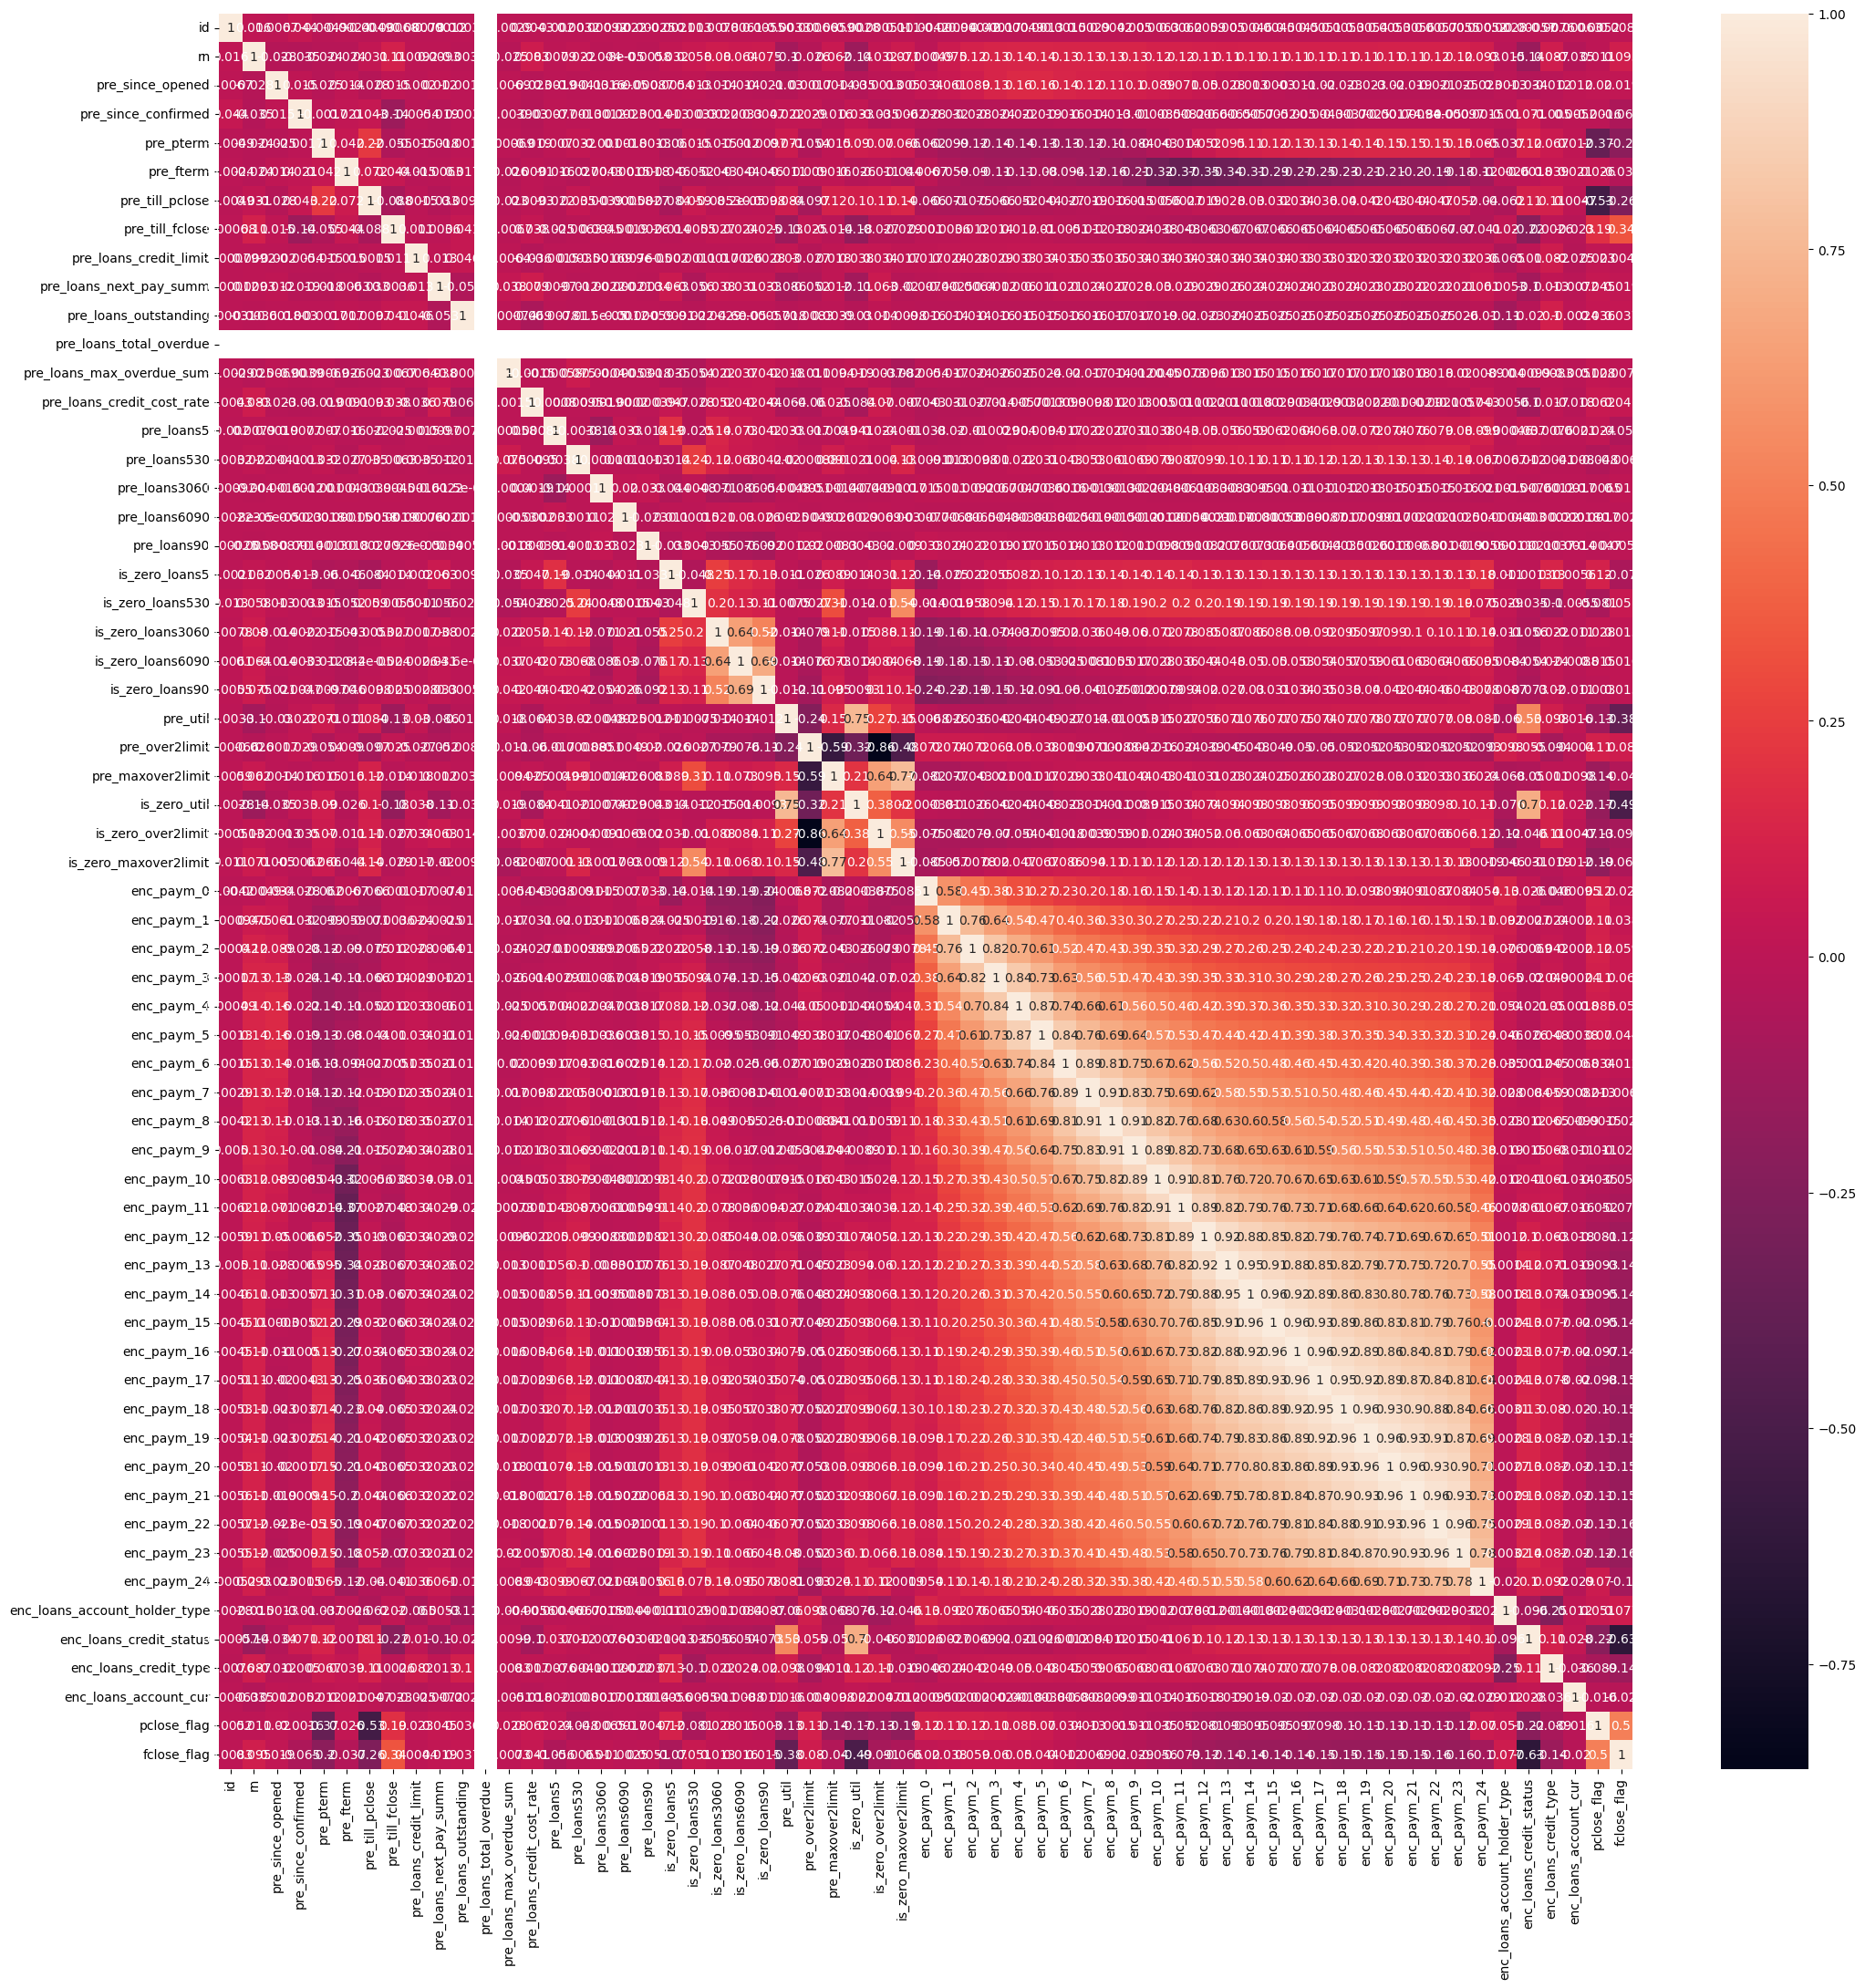

In [171]:
fig, ax = plt.subplots(figsize = (25, 25))
sns.heatmap(data.corr(), annot=True);

In [172]:
data.drop(columns=['rn','pre_loans_total_overdue','pre_loans_max_overdue_sum',
       'pre_loans_outstanding', 'pre_till_pclose',
       'pre_till_fclose', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'pre_loans5', 'pre_loans530', 'pre_loans3060',
       'pre_loans6090', 'pre_loans90', 'pclose_flag', 'fclose_flag',
       'enc_loans_account_cur'], inplace=True)

In [173]:
data.dtypes

id                               int64
pre_since_opened                 int64
pre_since_confirmed              int64
pre_pterm                        int64
pre_fterm                        int64
pre_loans_credit_limit           int64
pre_loans_next_pay_summ          int64
pre_loans_credit_cost_rate       int64
is_zero_loans5                   int64
is_zero_loans530                 int64
is_zero_loans3060                int64
is_zero_loans6090                int64
is_zero_loans90                  int64
pre_util                         int64
pre_over2limit                   int64
pre_maxover2limit                int64
enc_paym_0                       int64
enc_paym_1                       int64
enc_paym_2                       int64
enc_paym_3                       int64
enc_paym_4                       int64
enc_paym_5                       int64
enc_paym_6                       int64
enc_paym_7                       int64
enc_paym_8                       int64
enc_paym_9               

In [174]:
data_2 = pd.read_csv(path+'/target.csv')

In [175]:
data_2 = data_2.iloc[:250000]
data_2.head()

id  flag
0   0     0
1   1     0
2   2     0
3   3     0
4   4     0

In [176]:
data_2.shape

(250000, 2)

In [177]:
merged_data = pd.merge(data, data_2 , on = 'id')
merged_data.shape

(1974724, 45)

In [178]:
merged_data.drop(columns=['id'], inplace=True)

In [179]:
merged_data.head()

pre_since_opened  pre_since_confirmed  ...  enc_loans_credit_type  flag
0                18                    9  ...                      4     0
1                18                    9  ...                      4     0
2                18                    9  ...                      3     0
3                 4                    1  ...                      1     0
4                 5                   12  ...                      4     0

[5 rows x 44 columns]

In [180]:
merged_data = merged_data.iloc[:6000]

In [181]:
merged_data.isna().sum()

pre_since_opened                 0
pre_since_confirmed              0
pre_pterm                        0
pre_fterm                        0
pre_loans_credit_limit           0
pre_loans_next_pay_summ          0
pre_loans_credit_cost_rate       0
is_zero_loans5                   0
is_zero_loans530                 0
is_zero_loans3060                0
is_zero_loans6090                0
is_zero_loans90                  0
pre_util                         0
pre_over2limit                   0
pre_maxover2limit                0
enc_paym_0                       0
enc_paym_1                       0
enc_paym_2                       0
enc_paym_3                       0
enc_paym_4                       0
enc_paym_5                       0
enc_paym_6                       0
enc_paym_7                       0
enc_paym_8                       0
enc_paym_9                       0
enc_paym_10                      0
enc_paym_11                      0
enc_paym_12                      0
enc_paym_13         

In [182]:
flag_counts = merged_data['flag'].value_counts()
print("Количество значений в столбце 'flag':")
print(flag_counts)
print()
flag_counts = merged_data['flag'].value_counts('0')
print("Соотношение значений в столбце 'flag':")
print(flag_counts)

Количество значений в столбце 'flag':
flag
0    5904
1      96
Name: count, dtype: int64

Соотношение значений в столбце 'flag':
flag
0    0.984
1    0.016
Name: proportion, dtype: float64


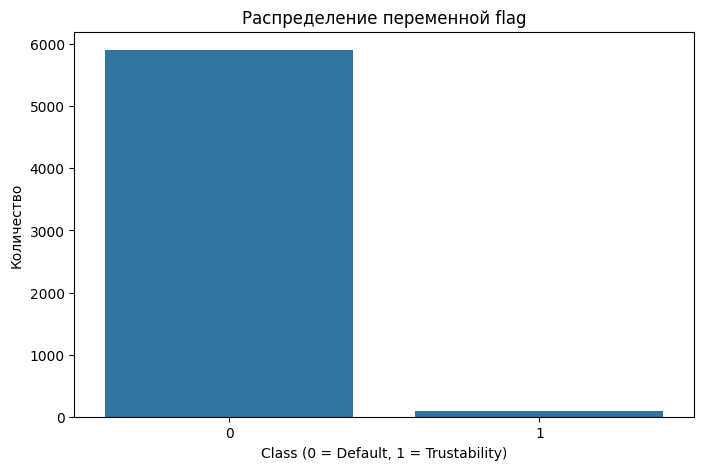

In [183]:
plt.figure(figsize=(8, 5))
sns.countplot(x="flag", data=merged_data)
plt.title("Распределение переменной flag")
plt.xlabel("Class (0 = Default, 1 = Trustability)")
plt.ylabel("Количество")
plt.show()

In [184]:
threshold = 0.9

In [185]:
def set_highly_correlated_columns(corr, threshold):
    corr_matrix = corr.abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    highly_correlated_columns = [column for column in upper.columns if any(upper[column] > threshold)]
    return highly_correlated_columns

In [186]:
def corr_matrix(corr, threshold):
    plt.figure(figsize=(25,25))

    sns.heatmap(corr, annot=True)

    plt.title('Корреляция признаков')
    plt.show()

    corr_df = pd.DataFrame(corr)
    correlation_matrix = corr_df.corr()

    highly_correlated_columns = set_highly_correlated_columns(corr, threshold=threshold)

    print('highly_correlated_columns:')

    # Print the highly correlated column pairs
    for column in highly_correlated_columns:
            print(column)

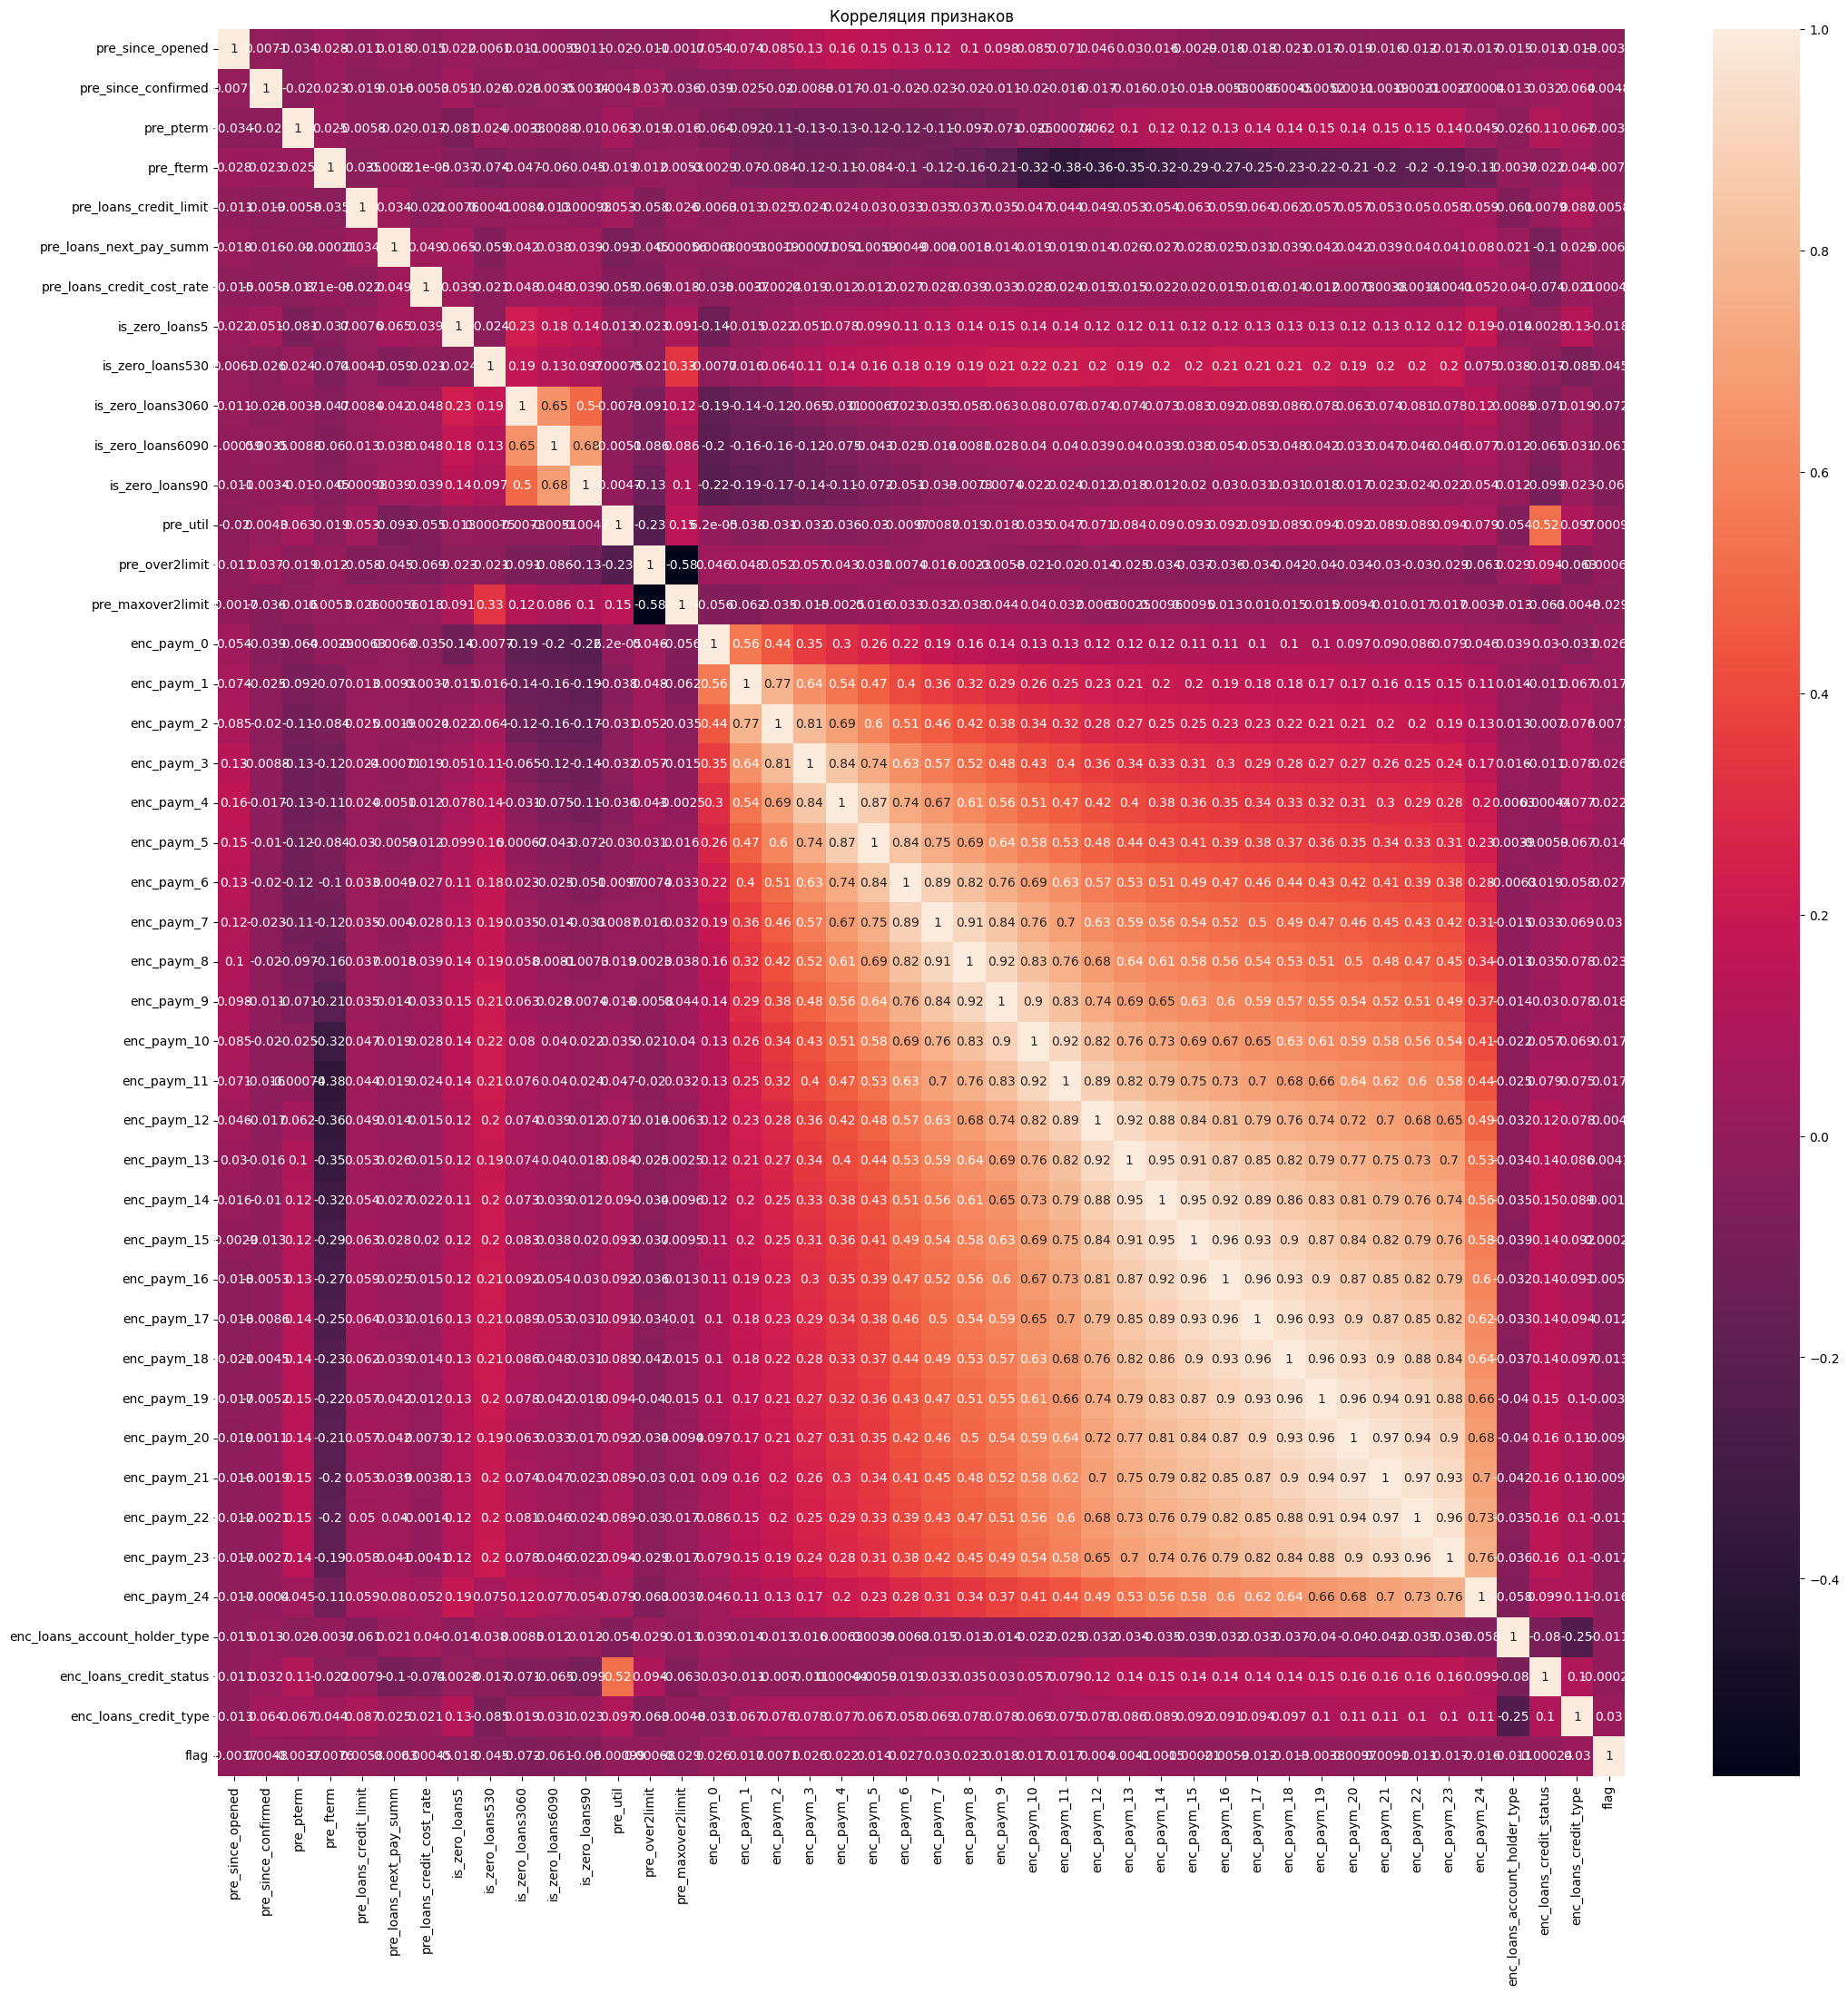

highly_correlated_columns:
enc_paym_8
enc_paym_9
enc_paym_11
enc_paym_13
enc_paym_14
enc_paym_15
enc_paym_16
enc_paym_17
enc_paym_18
enc_paym_19
enc_paym_20
enc_paym_21
enc_paym_22
enc_paym_23


In [187]:
corr_matrix(merged_data.corr(), threshold=threshold)

In [188]:
def drop_highly_correlated(df, threshold):
    to_drop = set_highly_correlated_columns(df.corr(), threshold=threshold)
    return df.drop(columns=to_drop)

In [189]:
data_filtered = drop_highly_correlated(merged_data, threshold)

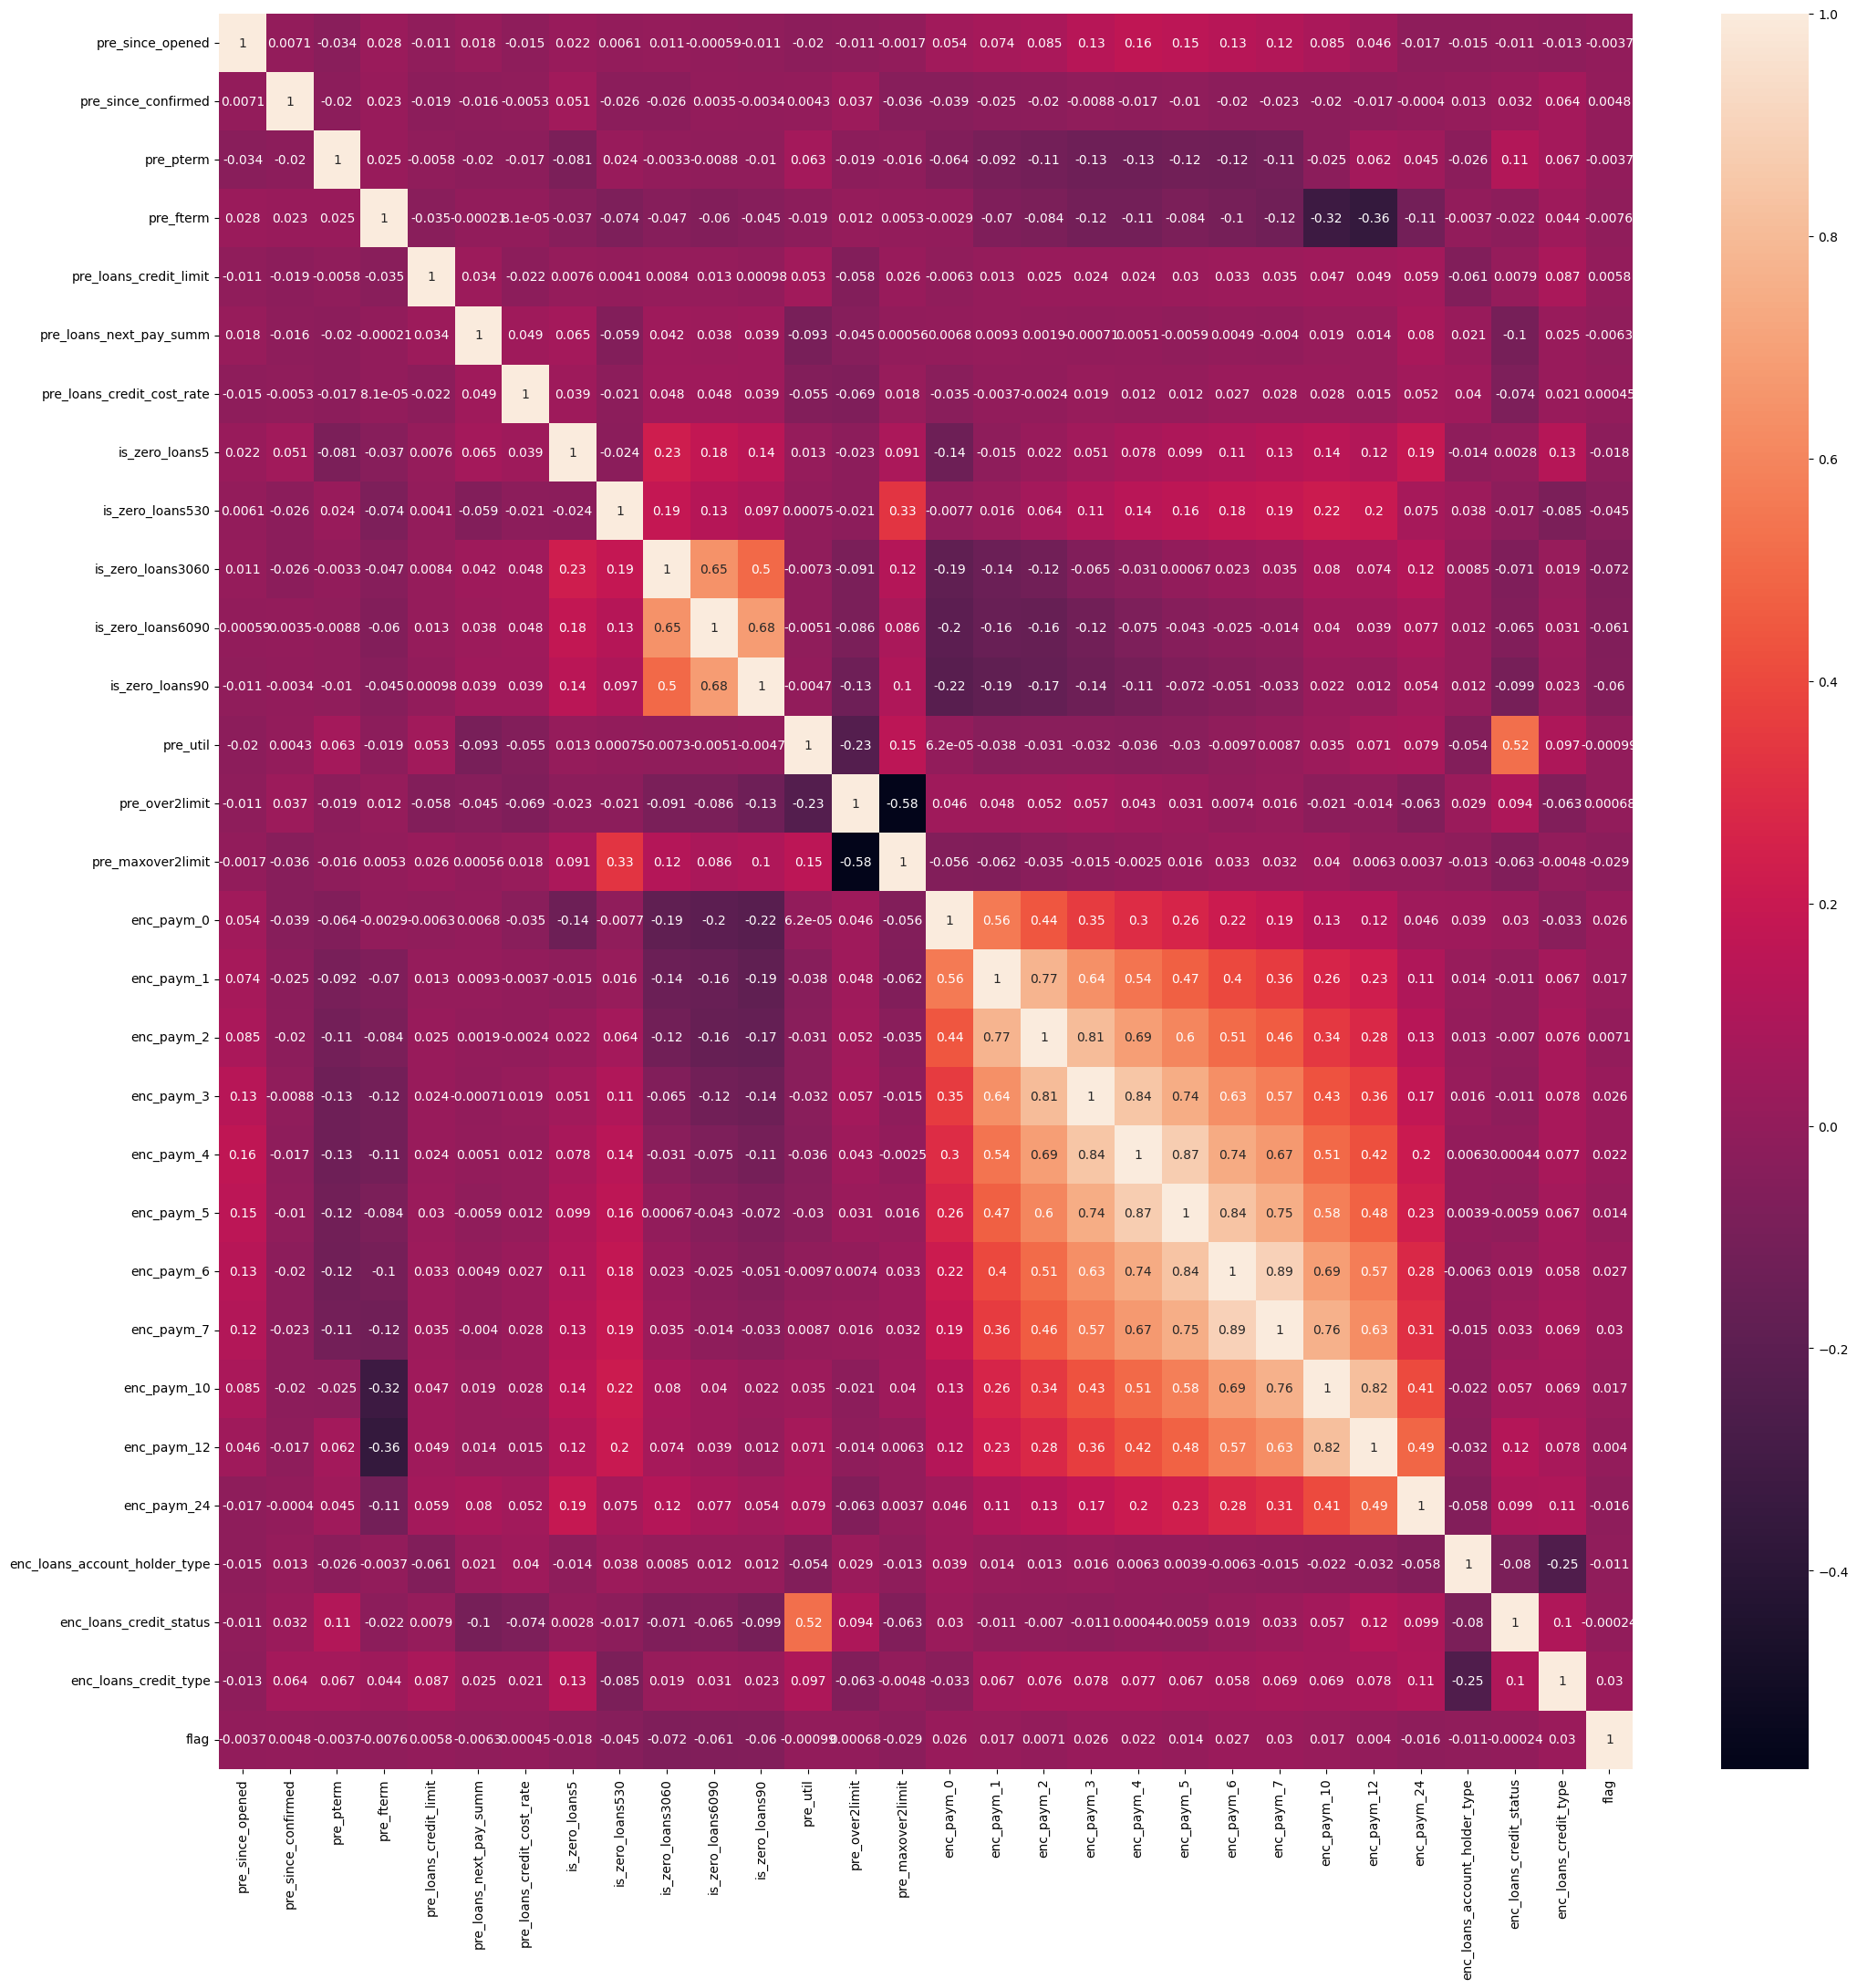

In [190]:
fig, ax = plt.subplots(figsize = (25, 25))
sns.heatmap(data_filtered.corr(), annot=True);

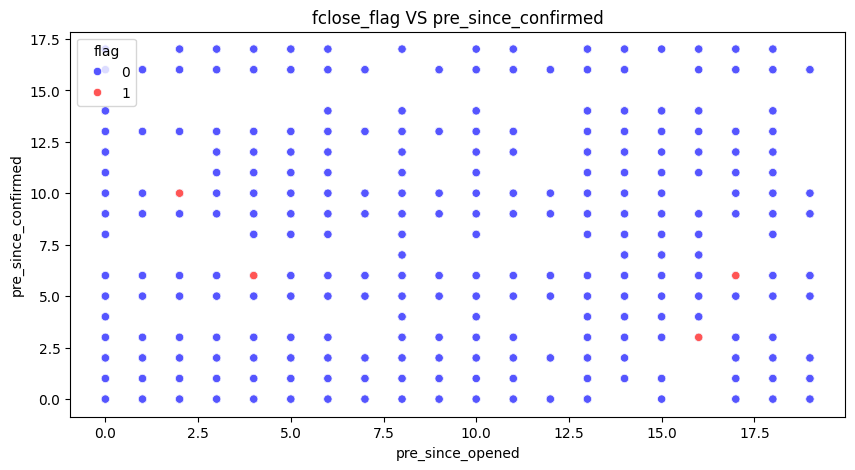

In [191]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=data_filtered, #датасет
    x='pre_since_opened', #ось абсцисс
    y='pre_since_confirmed', #ось ординат
    hue='flag', #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('fclose_flag VS pre_since_confirmed');

In [192]:
pd.set_option('display.max_columns', None)
data_filtered.head()

pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
0                18                    9          2          3   
1                18                    9         14         14   
2                18                    9          4          8   
3                 4                    1          9         12   
4                 5                   12         15          2   

   pre_loans_credit_limit  pre_loans_next_pay_summ  \
0                      11                        3   
1                       0                        3   
2                      11                        0   
3                      12                        2   
4                      10                        2   

   pre_loans_credit_cost_rate  is_zero_loans5  is_zero_loans530  \
0                          11               1                 1   
1                          11               1                 1   
2                           8               1                 1   
3                           4               0                 1   
4                           4               1                 1   

   is_zero_loans3060  is_zero_loans6090  is_zero_loans90  pre_util  \
0                  1                  1                1        16   
1                  1                  1                1        16   
2                  1                  1                1        15   
3                  1                  1                1        16   
4                  1                  1                1        16   

   pre_over2limit  pre_maxover2limit  enc_paym_0  enc_paym_1  enc_paym_2  \
0               2                 17           0           0           3   
1               2                 17           0           0           0   
2               2                 17           0           0           0   
3               2                 17           1           0           0   
4               2                 17           0           0           0   

   enc_paym_3  enc_paym_4  enc_paym_5  enc_paym_6  enc_paym_7  enc_paym_10  \
0           3           3           3           3           3            3   
1           0           0           0           0           0            0   
2           0           0           0           0           0            0   
3           0           0           0           0           0            0   
4           0           0           0           0           3            3   

   enc_paym_12  enc_paym_24  enc_loans_account_holder_type  \
0            3            4                              1   
1            0            4                              1   
2            0            4                              1   
3            3            4                              1   
4            3            4                              1   

   enc_loans_credit_status  enc_loans_credit_type  flag  
0                        3                      4     0  
1                        3                      4     0  
2                        2                      3     0  
3                        3                      1     0  
4                        3                      4     0

In [193]:
pd.reset_option('display.max_columns')

Применение One-Hot-Encoder (Pandas)

In [194]:
data_filtered = pd.get_dummies(data_filtered, dtype=int, columns=['enc_loans_account_holder_type'], prefix='enc_loans_account_holder_type', drop_first=True)
data_filtered = pd.get_dummies(data_filtered, dtype=int, columns=['enc_loans_credit_status'], prefix='enc_loans_credit_status', drop_first=True)
data_filtered = pd.get_dummies(data_filtered, dtype=int, columns=['enc_loans_credit_type'], prefix='enc_loans_credit_type', drop_first=True)
for i in range(25):
    if f'enc_paym_{i}' in data_filtered.columns:
        data_filtered = pd.get_dummies(data_filtered, dtype=int, columns=[f'enc_paym_{i}'], prefix=f'enc_paym_{i}', drop_first=True)

In [195]:
data_filtered.shape

(6000, 63)

In [196]:
data_filtered.head()

pre_since_opened  pre_since_confirmed  ...  enc_paym_24_3  enc_paym_24_4
0                18                    9  ...              0              1
1                18                    9  ...              0              1
2                18                    9  ...              0              1
3                 4                    1  ...              0              1
4                 5                   12  ...              0              1

[5 rows x 63 columns]

In [197]:
X = data_filtered.drop(columns=['flag'])
y = data_filtered['flag']

In [198]:
X.shape, y.shape

((6000, 62), (6000,))

In [199]:
#уменьшение выборки для демонстрации работы TPOT и H2O
train_data_X, X_test, train_data_y, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [200]:
from imblearn.over_sampling import SMOTE

# Создание экземпляра SMOTE
smote = SMOTE()

# Применение SMOTE к данным
train_data_X, train_data_y = smote.fit_resample(train_data_X, train_data_y)

In [201]:
print(train_data_X.shape, train_data_y.shape)

(8858, 62) (8858,)


In [202]:
flag_counts = train_data_y.value_counts()
print("Количество значений в столбце 'flag':")
print(flag_counts)
print()
flag_counts = train_data_y.value_counts('0')
print("Cоотношение значений в столбце 'flag':")
print(flag_counts)
print()

Количество значений в столбце 'flag':
flag
0    4429
1    4429
Name: count, dtype: int64

Cоотношение значений в столбце 'flag':
flag
0    0.5
1    0.5
Name: proportion, dtype: float64



In [203]:
flag_counts = y_test.value_counts()
print("Количество значений в столбце 'flag':")
print(flag_counts)
print()
flag_counts = y_test.value_counts('0')
print("Cоотношение значений в столбце 'flag':")
print(flag_counts)
print()

Количество значений в столбце 'flag':
flag
0    1475
1      25
Name: count, dtype: int64

Cоотношение значений в столбце 'flag':
flag
0    0.983333
1    0.016667
Name: proportion, dtype: float64



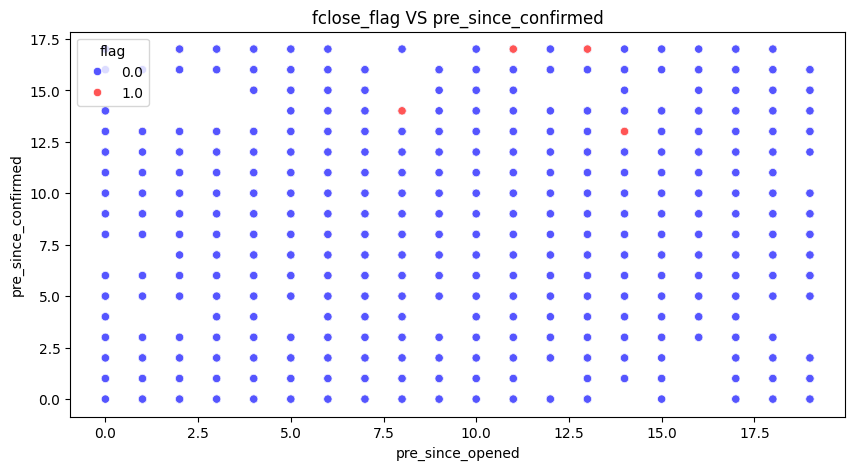

In [204]:
fig, ax = plt.subplots(figsize = (10, 5)) #фигура + координатная плоскость
#Строим диаграмму рассеяния
sns.scatterplot(
    data=train_data_X, #датасет
    x='pre_since_opened', #ось абсцисс
    y='pre_since_confirmed', #ось ординат
    hue=y, #группировка
    palette='seismic', #палитра
    ax=ax, #координатная плоскость
);
#Задаём название графика
ax.set_title('fclose_flag VS pre_since_confirmed');

In [205]:
X_train, X_val, y_train, y_val = train_test_split(train_data_X, train_data_y, test_size=0.3, random_state=42)

In [206]:
def metrics(y_test, y_pred, y_proba):
    # Вычисление метрик
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
    print(f"ROC_AUC: {roc_auc_score(y_test, y_proba):.4f}")
    print()
    # Матрица ошибок
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    # Полный отчет
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Логистическая регрессия

In [207]:
from sklearn.linear_model import LogisticRegression

In [208]:
log_reg_model = LogisticRegression() #class_weight='balanced')
log_reg_model.fit(X_train, y_train)

LogisticRegression()

In [209]:
y_log_pred = log_reg_model.predict(X_test)
y_log_proba = log_reg_model.predict_proba(X_test)[:, 1]

In [210]:
metrics(y_test, y_log_pred, y_log_proba)

Accuracy: 0.8953
Precision: 0.0286
Recall: 0.1600
F1-Score: 0.0485
ROC_AUC: 0.4876

Confusion Matrix:
 [[1339  136]
 [  21    4]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94      1475
           1       0.03      0.16      0.05        25

    accuracy                           0.90      1500
   macro avg       0.51      0.53      0.50      1500
weighted avg       0.97      0.90      0.93      1500



In [211]:
log_reg_model.fit(X_val, y_val)

LogisticRegression()

In [212]:
y_log_pred = log_reg_model.predict(X_test)
y_log_proba = log_reg_model.predict_proba(X_test)[:, 1]

In [213]:
metrics(y_test, y_log_pred, y_log_proba)

Accuracy: 0.9000
Precision: 0.0155
Recall: 0.0800
F1-Score: 0.0260
ROC_AUC: 0.4833

Confusion Matrix:
 [[1348  127]
 [  23    2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.95      1475
           1       0.02      0.08      0.03        25

    accuracy                           0.90      1500
   macro avg       0.50      0.50      0.49      1500
weighted avg       0.97      0.90      0.93      1500



## Обучение TPOT

### Функции метрик

In [214]:
def tpot_prediction(test_data, model):
    y_pred = model.predict(test_data)
    y_proba = model.predict_proba(test_data)[:, 1]
    return y_pred, y_proba

### Процесс обучения

In [215]:
#%pip install tpot

In [216]:
from sklearn import utils
import tpot
from tpot import TPOTClassifier

In [217]:
tpot_generations = [5, 10]
tpot_popsize = [50, 100]
tpot_models = []

In [218]:
# проводим обучение нескольких моделей tpot
for gen_param in tpot_generations:
    for pop_param in tpot_popsize:
        tpot = TPOTClassifier(
            generations=gen_param,
            population_size=pop_param,
            random_state=42,
            cv=5,
            #n_jobs=-1,
            scorers='recall',
        )
        tpot.fit(X_train, y_train)
        tpot_models.append(tpot)

Generation:  30%|███       | 3/10 [1:02:03<2:24:47, 1241.00s/it]


In [219]:
for tpot in tpot_models:
    print(f'{tpot_models.index(tpot)+1} tpot model: generations={tpot.generations}, pop_size={tpot.population_size}')
    y_pred, y_proba = tpot_prediction(X_val, tpot)
    print('Validation metrics:')
    metrics(y_val, y_pred, y_proba)

    print('\nBest pipeline steps:', end='\n')
    for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
        print(f'{idx}. {transform}')
    
    test_predictions, test_probablity = tpot_prediction(X_test, tpot)
    print('Test metrics:')
    metrics(y_test, test_predictions, test_probablity)
    
    if not (tpot_models.index(tpot) == len(tpot_models)-1):
        print('\n'+('-='*20)+'-\n')

1 tpot model: generations=5, pop_size=50
Validation metrics:
Accuracy: 0.6283
Precision: 0.5748
Recall: 0.9947
F1-Score: 0.7286
ROC_AUC: 0.6291

Confusion Matrix:
 [[ 344  981]
 [   7 1326]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.26      0.41      1325
           1       0.57      0.99      0.73      1333

    accuracy                           0.63      2658
   macro avg       0.78      0.63      0.57      2658
weighted avg       0.78      0.63      0.57      2658


Best pipeline steps:
1. MaxAbsScaler()
2. Passthrough()
3. FeatureUnion(transformer_list=[('featureunion',
                                FeatureUnion(transformer_list=[('binarizer',
                                                                Binarizer(threshold=0.0126479301056)),
                                                               ('columnonehotencoder',
                                                                ColumnOneHotEncode

In [220]:
# Экспорт лучшего пайплайна в виде Python-кода
# tpot.export('tpot_pipeline.py')

## Обучение H2O

In [221]:
#%pip install h2o

In [222]:
import h2o
from h2o.automl import H2OAutoML

In [223]:
# Ячейка 2: Инициализация H2O и загрузка данных
h2o.init(nthreads=-1, max_mem_size="4G", ip="127.0.0.1", port='54321')

Checking whether there is an H2O instance running at http://127.0.0.1:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.451-b10, mixed mode)
  Starting server from C:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\AntMur00\AppData\Local\Temp\tmpr4nbizyb
  JVM stdout: C:\Users\AntMur00\AppData\Local\Temp\tmpr4nbizyb\h2o_AntMur00_started_from_python.out
  JVM stderr: C:\Users\AntMur00\AppData\Local\Temp\tmpr4nbizyb\h2o_AntMur00_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Asia/Yekaterinburg
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    1 month and 10 days
H2O_cluster_name:           H2O_from_python_AntMur00_tzod9u
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.541 Gb
H2O_cluster_total_cores:    6
H2O_cluster_allowed_cores:  6
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.10.10 final
--------------------------  -------------------------------

In [224]:
print(f'X_train.shape :{X_train.shape}')
print(f'X_val.shape:{X_val.shape}')
print(f'X_test.shape:{X_test.shape}')

X_train.shape :(6200, 62)
X_val.shape:(2658, 62)
X_test.shape:(1500, 62)


In [225]:
h2o_train_y = y_train.apply(lambda x: "yes" if x == 1 else "no")
h2o_val_y = y_val.apply(lambda x: "yes" if x == 1 else "no")
h2o_y_test = y_test.apply(lambda x: "yes" if x == 1 else "no")

In [226]:
# Преобразование в H2O фреймы
train_h2o = h2o.H2OFrame(pd.concat([X_train, h2o_train_y], axis=1))
val_h2o = h2o.H2OFrame(pd.concat([X_val, h2o_val_y], axis=1))
test_h2o = h2o.H2OFrame(pd.concat([X_test, h2o_y_test], axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [227]:
# Определение целевой переменной и признаков
target = 'flag'
features = list(X_train.columns)

In [228]:
train_h2o

pre_since_opened    pre_since_confirmed    pre_pterm    pre_fterm    pre_loans_credit_limit    pre_loans_next_pay_summ    pre_loans_credit_cost_rate    is_zero_loans5    is_zero_loans530    is_zero_loans3060    is_zero_loans6090    is_zero_loans90    pre_util    pre_over2limit    pre_maxover2limit    enc_loans_account_holder_type_2    enc_loans_account_holder_type_3    enc_loans_account_holder_type_4    enc_loans_account_holder_type_6    enc_loans_credit_status_1    enc_loans_credit_status_2    enc_loans_credit_status_3    enc_loans_credit_status_4    enc_loans_credit_status_5    enc_loans_credit_type_1    enc_loans_credit_type_2    enc_loans_credit_type_3    enc_loans_credit_type_4    enc_loans_credit_type_5    enc_paym_0_1    enc_paym_0_2    enc_paym_0_3    enc_paym_1_1    enc_paym_1_2    enc_paym_1_3    enc_paym_2_1    enc_paym_2_2    enc_paym_2_3    enc_paym_3_1    enc_paym_3_2    enc_paym_3_3    enc_paym_4_1    enc_paym_4_2    enc_paym_4_3    enc_paym_5_1    enc_paym_5_2    enc_paym_5_3    enc_paym_6_1    enc_paym_6_2    enc_paym_6_3    enc_paym_7_1    enc_paym_7_2    enc_paym_7_3    enc_paym_10_1    enc_paym_10_2    enc_paym_10_3    enc_paym_12_1    enc_paym_12_2    enc_paym_12_3    enc_paym_24_2    enc_paym_24_3    enc_paym_24_4  flag
------------------  ---------------------  -----------  -----------  ------------------------  -------------------------  ----------------------------  ----------------  ------------------  -------------------  -------------------  -----------------  ----------  ----------------  -------------------  ---------------------------------  ---------------------------------  ---------------------------------  ---------------------------------  ---------------------------  ---------------------------  ---------------------------  ---------------------------  ---------------------------  -------------------------  -------------------------  -------------------------  -------------------------  -------------------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  --------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ------
                 8                      7            9            0                        16                          2                             4                 1                   1                    1                    1                  1          16                 2                   17                                  0                                  0                                  0                                  0                            0                            0                            1                            0                            0                          1                          0                          0                          0                          0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0               0                0                0                1                0                0                1                0                0                1  no
                17                      5            4            8                         6                          2                             7                 0                   0                    1 

In [229]:
# Запуск H2O AutoML
aml = H2OAutoML(max_models=50, max_runtime_secs=3600, seed=42, verbosity='info', nfolds=5)
aml.train(x=features, y=target, training_frame=train_h2o, validation_frame=val_h2o)

AutoML progress: |
02:59:58.80: Project: AutoML_1_20250508_25958
02:59:58.80: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
02:59:58.80: Setting stopping tolerance adaptively based on the training frame: 0.01270001270001905
02:59:58.80: Build control seed: 42
02:59:58.81: training frame: Frame key: AutoML_1_20250508_25958_training_Key_Frame__upload_a2a47f77cd9fe81cb60d781ea4074dc0.hex    cols: 63    rows: 6200  chunks: 1    size: 87582  checksum: 456229863880434072
02:59:58.81: validation frame: Frame key: Key_Frame__upload_a8718bf506dca95a475872883784b19.hex    cols: 63    rows: 2658  chunks: 1    size: 40570  checksum: 456231327622804812
02:59:58.81: leaderboard frame: NULL
02:59:58.81: blending frame: NULL
02:59:58.81: response column: flag
02:59:58.81: fold column: null
02:

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_grid_1_AutoML_1_20250508_25958_model_4


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    121                121                         398156                 17           17           16.8512       1             323           256.909

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 3.68359980115278e-05
RMSE: 0.006069266678234513
LogLoss: 0.0008238713528632087
Mean Per-Class Error: 0.0
AUC: 1.0
AUCPR: 1.0
Gini: 1.0

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7257338432406701
       no    yes    Error    Rate
-----  ----  -----  -------  ------------
no     3104  0      0        (0.0/3104.0)
yes    0     3096   0        (0.0/3096.0)
Total  3104  3096   0        (0.0/6200.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value    idx
---------------------------  -----------  -------  -----
max f1                       0.725734     1        185
max f2                       0.725734     1        185
max f0point5                 0.725734     1        185
max accuracy                 0.725734     1        185
max precision                0.999976     1        0
max recall                   0.725734     1        185
max specificity              0.999976     1        0
max absolute_mcc             0.725734     1        185
max min_per_class_accuracy   0.725734     1        185
max mean_per_class_accuracy  0.725734     1        185
max tns                      0.999976     3104     0
max fns                      0.999976     3046     0
max fps                      9.9499e-06   3104     399
max tps                      0.725734     3096     185
max tnr                      0.999976     1        0
max fnr                      0.999976     0.98385  0
max fpr                      9.9499e-06   1        399
max tpr                      0.725734     1        185

Gains/Lift Table: Avg response rate: 49,94 %, avg score: 49,93 %
group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain     cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  -------  -----------------  --------------------
1        0.0101613                   0.999966           2.00258  2.00258            1                0.999974     1                           0.999974            0.0203488       0.0203488                  100.258  100.258            0.0203488
2        0.02                        0.999959           2.00258  2.00258            1                0.999962     1                           0.999968            0.0197028       0.0400517                  100.258  100.258            0.0400517
3        0.03                        0.999957           2.00258  2.00258            1                0.999957     1                           0.999965            0.0200258       0.0600775                  100.258  100.258            0.0600775
4        0.0403226                   0.999951           2.00258  2.00258            1                0.999954     1                           0.999962            0.0206718       0.0807494                  100.258  100.258            0.0807494
5        0.05                        0.999945           2.00258  2.00258            1                0.999948     1                           0.999959            0.0193798       0.100129                   100.25

In [230]:
# Вывод Leaderboard
print("\nLeaderboard:")
print(aml.leaderboard)


Leaderboard:
model_id                                          auc    logloss     aucpr    mean_per_class_error       rmse         mse
GBM_grid_1_AutoML_1_20250508_25958_model_4   0.999148  0.0266205  0.999343              0.00806703  0.0815757  0.00665459
GBM_grid_1_AutoML_1_20250508_25958_model_11  0.9991    0.0300517  0.999281              0.00903977  0.0875659  0.00766779
GBM_grid_1_AutoML_1_20250508_25958_model_9   0.999034  0.0273359  0.999245              0.00823186  0.0816379  0.00666475
GBM_3_AutoML_1_20250508_25958                0.999032  0.0320253  0.999199              0.00951677  0.0899996  0.00809994
GBM_grid_1_AutoML_1_20250508_25958_model_10  0.999006  0.0300351  0.999177              0.00887161  0.0869823  0.00756592
GBM_grid_1_AutoML_1_20250508_25958_model_17  0.999005  0.0296212  0.999185              0.00919877  0.0853129  0.0072783
GBM_4_AutoML_1_20250508_25958                0.999     0.0310634  0.999205              0.00919294  0.0877409  0.00769846
GBM_grid_1_

In [231]:
# Получение лучшей модели
model_ids = aml.leaderboard.as_data_frame()['model_id'].tolist()
# 2. Выбираем топ-3 модели
top_n = 3
model_ids = model_ids[:top_n]

models = [h2o.get_model(mid) for mid in model_ids]

best_model = models[0]

c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [232]:
# Готовим таблицу для результатов
results = []

# Предсказываем и оцениваем каждую модель
for model in models:
    preds = model.predict(test_h2o)
    pred_labels = preds.as_data_frame()['yes']
    pred_labels = pred_labels.apply(lambda x: 1 if x > 0.5 else 0)
    pred_probs = preds.as_data_frame()['yes']  # вероятность класса 1
    print(f'Model {models.index(model)+1}: {model.algo}:{model.model_id}')
    print(f'\nModel parameters:\n{model.params}')
    print(f'\nPredications:\n{preds}')

    # Истинные значения
    y_true = y_test.values
    y_true = pd.get_dummies(y_true, dtype=int, columns=['flag'], drop_first=True)


    # Метрики
    acc = accuracy_score(y_true, pred_labels)
    prec = precision_score(y_true, pred_labels)
    rec = recall_score(y_true, pred_labels)
    f1 = f1_score(y_true, pred_labels)
    roc_auc = roc_auc_score(y_true, pred_probs)

    results.append({
        'Model Name': model.model_id,
        'Algorithm': model.algo,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC AUC': roc_auc
    })

    print(f'Confusion Matrix:\n{confusion_matrix(y_true, pred_labels)}')
    print(f'\nClassification Report:\n{classification_report(y_true, pred_labels)}')

    if model.algo in ('stackedensemble'):
        print(f'Base models:\n{model.base_models}')
        print(f'\nMetalearner:\n{model.metalearner().algo}')

    if not (models.index(model) == len(models)-1):
        print('\n'+('-='*20)+'-\n')

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Model 1: gbm:GBM_grid_1_AutoML_1_20250508_25958_model_4

Model parameters:
{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_grid_1_AutoML_1_20250508_25958_model_4', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_grid_1_AutoML_1_20250508_25958_model_4'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20250508_25958_training_Key_Frame__upload_a2a47f77cd9fe81cb60d781ea4074dc0.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20250508_25958_training_Key_Frame__upload_a2a47f77cd9fe81cb60d781ea4074dc0.hex'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20250508_25958_training_Key_Frame__upload_a2a47f77cd9f

c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
Model 2: gbm:GBM_grid_1_AutoML_1_20250508_25958_model_11

Model parameters:
{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_grid_1_AutoML_1_20250508_25958_model_11', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_grid_1_AutoML_1_20250508_25958_model_11'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20250508_25958_training_Key_Frame__upload_a2a47f77cd9fe81cb60d781ea4074dc0.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20250508_25958_training_Key_Frame__upload_a2a47f77cd9fe81cb60d781ea4074dc0.hex'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20250508_25958_training_Key_Frame__upload_a2a47f77cd9fe81cb60d781ea4074dc0.he

c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
Model 3: gbm:GBM_grid_1_AutoML_1_20250508_25958_model_9

Model parameters:
{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GBM_grid_1_AutoML_1_20250508_25958_model_9', 'type': 'Key<Model>', 'URL': '/3/Models/GBM_grid_1_AutoML_1_20250508_25958_model_9'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20250508_25958_training_Key_Frame__upload_a2a47f77cd9fe81cb60d781ea4074dc0.hex', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_1_20250508_25958_training_Key_Frame__upload_a2a47f77cd9fe81cb60d781ea4074dc0.hex'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_1_20250508_25958_training_Key_Frame__upload_a2a47f77cd9fe81cb60d781ea4074dc0.hex',

c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\AntMur00\Desktop\Magister22\LoanStatus\.venv\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [233]:
preds

predict             no          yes
---------  -----------  -----------
no         0.999981     1.90475e-05
no         0.999233     0.000767084
no         0.988574     0.0114259
no         0.999994     5.95336e-06
no         0.999356     0.000644167
no         0.999599     0.000400872
no         0.999793     0.000207292
yes        0.000831293  0.999169
no         0.999674     0.000326453
no         0.999921     7.94935e-05
[1500 rows x 3 columns]

In [234]:
print(pred_labels)
print(y_true)

0       0
1       0
2       0
3       0
4       0
       ..
1495    0
1496    0
1497    0
1498    1
1499    0
Name: yes, Length: 1500, dtype: int64
      1
0     0
1     0
2     0
3     0
4     0
...  ..
1495  0
1496  0
1497  0
1498  0
1499  0

[1500 rows x 1 columns]


In [235]:
results_df = pd.DataFrame(results)
results_df.head()

Model Name Algorithm  ...  F1-score   ROC AUC
0   GBM_grid_1_AutoML_1_20250508_25958_model_4       gbm  ...  0.108108  0.490305
1  GBM_grid_1_AutoML_1_20250508_25958_model_11       gbm  ...  0.100000  0.481193
2   GBM_grid_1_AutoML_1_20250508_25958_model_9       gbm  ...  0.108108  0.499444

[3 rows x 7 columns]

In [236]:
'''
for model in models:
    model_path = h2o.save_model(model=model, path="h2o_models", force=True)
    print(f"Model saved to: {model_path}")
'''

'\nfor model in models:\n    model_path = h2o.save_model(model=model, path="h2o_models", force=True)\n    print(f"Model saved to: {model_path}")\n'

In [237]:
h2o.shutdown()

H2O session _sid_9591 closed.


C:\Users\AntMur00\AppData\Local\Temp\ipykernel_17888\2900054706.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()
